In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [473]:
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
import os
from tqdm import tqdm_notebook
from scipy.cluster import hierarchy
from matplotlib.colors import ListedColormap

In [13]:
def create_count_matrix(input_dir):
    mat = []
    for filename in os.listdir(input_dir):
        sample_id = os.path.splitext(filename)[0]
        row_names = None
        df = pd.read_table(os.path.join(input_dir, filename), header=None)
        if row_names is None:
            row_names = ['|'.join(row) for row in df.iloc[:, [0, 3]].itertuples(index=False)]
        df.index = df.iloc[:, 3]
        cov = df.iloc[:, 4].copy()
        cov.name = sample_id
        mat.append(cov)
    mat = pd.concat(mat, axis=1)
    mat.index = row_names
    mat.index.name = 'peak_id'
    return mat

In [14]:
m = create_count_matrix('output/piranha_peak_cov_with_frequency/20/ZeroTruncatedNegativeBinomial/01/14')
m.head()

,SRR3103255,509442-A,423976-B,10515058-A,SRR3103249,511485-B,SRR3103245,498187-A,SRR3103251,511030-B,...,507867-B,Normal-7,SRR3103248,5474594-B,SRR3103258,SRR3103246,508877-B,SH327428-B,497497-B,509970-A
peak_id,,,,,,,,,,,,,,,,,,,,,
12979|peak_1,187,88,157,87,70,152,90,78,142,76,...,125,51,108,31,51,184,109,103,130,60
12985|peak_2,372,79,89,197,1430,35,165,133,284,139,...,107,129,386,114,237,712,145,127,39,93
12991|peak_3,346,108,79,245,1479,48,182,135,301,151,...,98,118,333,107,239,786,134,133,32,87
12993|peak_4,290,308,533,313,148,333,182,280,219,278,...,408,191,167,124,99,408,400,308,367,203
13011|peak_5,194,151,312,564,2085,125,212,903,137,201,...,387,658,556,860,308,730,780,506,99,497


In [302]:
print(m.shape)

(1727, 81)


## Read transcript information

In [94]:
transcript_table = pd.read_table('data/annotation/transcript_table/all.txt')
transcript_table.index = transcript_table.loc[:, 'transcript_id']
transcript_table.head()

,chrom,start,end,name,score,strand,gene_id,transcript_id,gene_name,transcript_name,gene_type,transcript_type
transcript_id,,,,,,,,,,,,
piR-hsa-18438,chr1,14629,14657,piR-hsa-18438,0,+,piR-hsa-18438,piR-hsa-18438,piR-hsa-18438,piR-hsa-18438,piRNA,piRNA
ENST00000619216.1,chr1,17368,17436,ENSG00000278267.1,0,-,ENSG00000278267.1,ENST00000619216.1,MIR6859-1,MIR6859-1-201,miRNA,miRNA
piR-hsa-7508,chr1,18535,18563,piR-hsa-7508,0,+,piR-hsa-7508,piR-hsa-7508,piR-hsa-7508,piR-hsa-7508,piRNA,piRNA
piR-hsa-23387,chr1,26805,26836,piR-hsa-23387,0,-,piR-hsa-23387,piR-hsa-23387,piR-hsa-23387,piR-hsa-23387,piRNA,piRNA
ENST00000473358.1,chr1,29553,31097,ENSG00000243485.5,0,+,ENSG00000243485.5,ENST00000473358.1,MIR1302-2HG,MIR1302-2HG-202,lncRNA,lncRNA


In [95]:
peak_transcript_ids = m.index.to_series().str.split('|', expand=True).iloc[:, 0].values
peak_ids = m.index.to_series().str.split('|', expand=True).iloc[:, 1].values
peak_transcript_names = transcript_table.loc[peak_transcript_ids, 'transcript_name'].values
peak_gene_types = transcript_table.loc[peak_transcript_ids, 'gene_type'].values
peak_labels = peak_ids + '|' + peak_transcript_names + '|' + peak_gene_types
peak_labels[:10]

array(['peak_1|12979|tRNA', 'peak_2|12985|tRNA', 'peak_3|12991|tRNA',
       'peak_4|12993|tRNA', 'peak_5|13011|tRNA', 'peak_6|13013|tRNA',
       'peak_7|13014|tRNA', 'peak_8|13016|tRNA', 'peak_9|13026|tRNA',
       'peak_10|13027|tRNA'], dtype=object)

## Read sample class information

In [26]:
sample_classes = pd.read_table('metadata/sample_classes.txt', header=None, 
                               names=['sample_id', 'group', 'stage'], index_col=0)
sample_classes.loc[:, 'stage'].fillna('Normal', inplace=True)
sample_classes.head()

,group,stage
sample_id,,
17402567-B,HCC_before,stage_A
249136-B,HCC_before,stage_A
385247-B,HCC_before,stage_A
497411-B,HCC_before,stage_A
498221-B,HCC_before,stage_A


## Select samples

In [38]:
sample_ids_hcc = sample_classes.query('group == "HCC_before"').index.tolist()
sample_ids_normal = sample_classes.query('(group == "Normal") or (group == "HBV")').index.tolist()
print('number of HCC samples: {}, normal samples: {}'.format(len(sample_ids_hcc), len(sample_ids_normal)))

X = m.loc[:, sample_ids_hcc + sample_ids_normal].T.copy()
y = (sample_classes.loc[X.index, 'stage'] != 'Normal').values.astype(np.int32)
X.head()

number of HCC samples: 30, normal samples: 13


peak_id,12979|peak_1,12985|peak_2,12991|peak_3,12993|peak_4,13011|peak_5,13013|peak_6,13014|peak_7,13016|peak_8,13026|peak_9,13027|peak_10,...,piR-hsa-7327_5|peak_1718,piR-hsa-7327_6|peak_1719,piR-hsa-7327_7|peak_1720,piR-hsa-793|peak_1721,piR-hsa-820|peak_1722,piR-hsa-9010|peak_1723,piR-hsa-9491|peak_1724,piR-hsa-952|peak_1725,piR-hsa-963|peak_1726,piR-hsa-993|peak_1727
17402567-B,239,249,216,826,311,589,442,55,270,136,...,27,25,21,191,681,350,1713,10887,589,815
249136-B,112,218,215,486,515,285,245,52,1225,162,...,64,51,53,760,50345,3734,10775,368876,50617,54962
385247-B,116,110,115,394,370,276,252,326,336,71,...,77,71,82,666,18386,1345,3109,135444,19659,25160
497411-B,209,232,263,948,253,816,643,126,706,196,...,91,104,82,517,463,374,2655,2785,438,582
498221-B,130,64,67,295,77,221,184,25,43,53,...,47,49,49,181,76,250,246,408,62,359


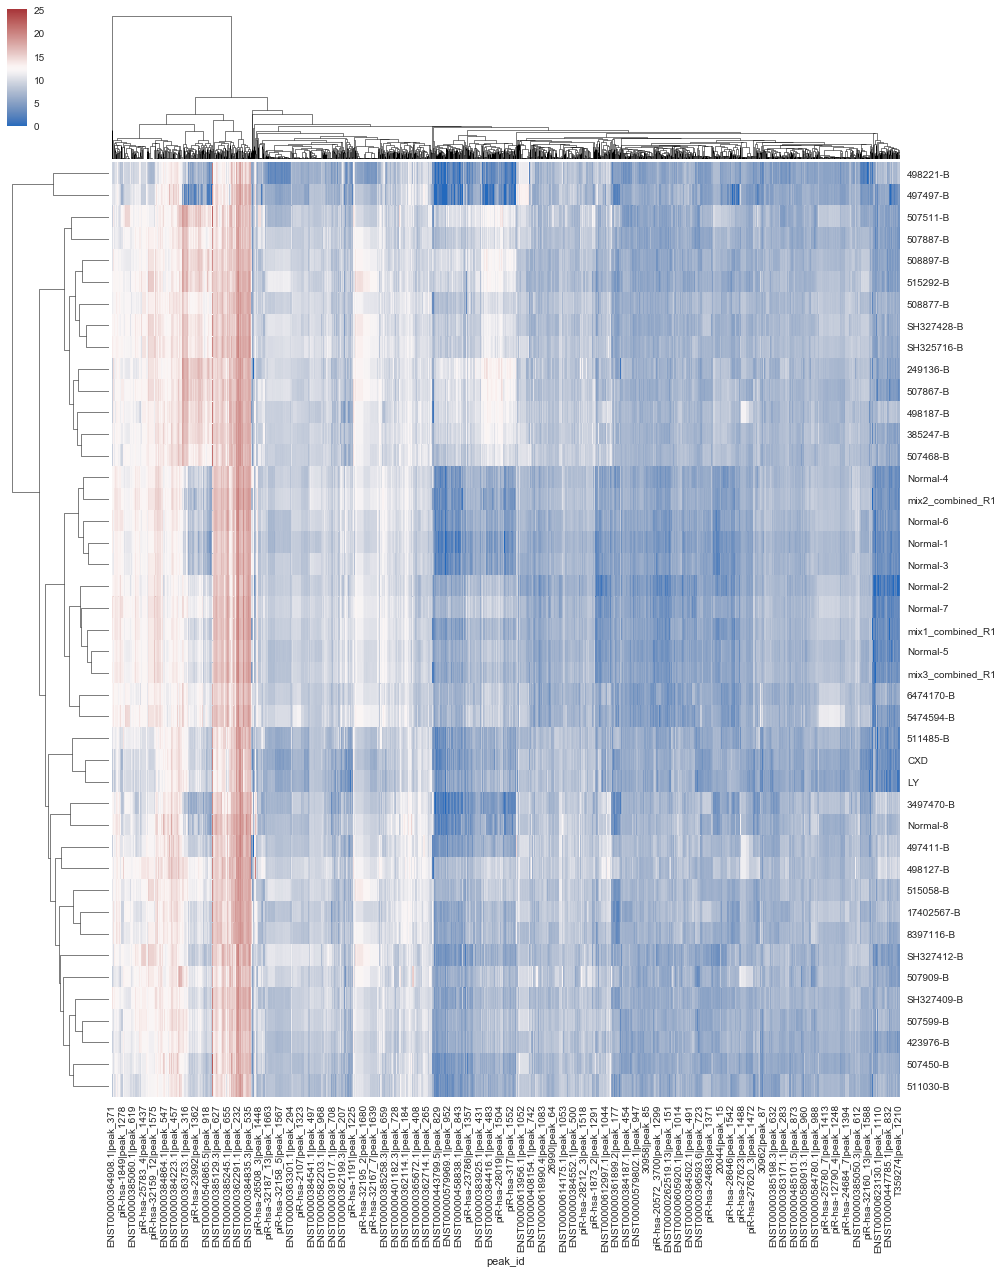

In [39]:
sns.clustermap(np.log2(X + 1), cmap='vlag', figsize=(16, 20))

## Normalize count matrix

In [35]:
top20_tids = pd.read_table('metadata/top20_tids.txt', header=None).iloc[:, 0]
tids = X.columns.to_series().str.split('|', expand=True).iloc[:, 0]
X_normed = X.astype('float')
top20_mask = ~tids.isin(top20_tids)
X_normed = 1e6*X_normed.div(X_normed.loc[:, ~top20_mask].sum(axis=1), axis=0)

In [37]:
X_normed.head()

peak_id,12979|peak_1,12985|peak_2,12991|peak_3,12993|peak_4,13011|peak_5,13013|peak_6,13014|peak_7,13016|peak_8,13026|peak_9,13027|peak_10,...,piR-hsa-7327_5|peak_1718,piR-hsa-7327_6|peak_1719,piR-hsa-7327_7|peak_1720,piR-hsa-793|peak_1721,piR-hsa-820|peak_1722,piR-hsa-9010|peak_1723,piR-hsa-9491|peak_1724,piR-hsa-952|peak_1725,piR-hsa-963|peak_1726,piR-hsa-993|peak_1727
17402567-B,9.900920,10.315184,8.948111,34.218241,12.883623,24.400174,18.310487,2.278454,11.185139,5.633996,...,1.118514,1.035661,0.869955,7.912450,28.211407,14.499255,70.963495,451.009670,24.400174,33.762550
249136-B,5.356952,10.426924,10.283434,23.245345,24.632413,13.631529,11.718332,2.487156,58.591661,7.748448,...,3.061115,2.439326,2.534986,36.350745,2407.997700,178.596949,515.367469,17643.312333,2421.007440,2628.828475
385247-B,4.170250,3.954548,4.134300,14.164470,13.301660,9.922319,9.059509,11.719841,12.079345,2.552481,...,2.768183,2.552481,2.947935,23.942988,660.984653,48.353332,111.769895,4869.270386,706.749554,904.512883
497411-B,4.852322,5.386309,6.106032,22.009575,5.873863,18.944951,14.928435,2.925323,16.391097,4.550503,...,2.112733,2.414553,1.903782,12.003112,10.749402,8.683102,61.640740,64.658931,10.168981,13.512207
498221-B,14.347608,7.063438,7.394536,32.558033,8.498198,24.390933,20.307383,2.759155,4.745747,5.849409,...,5.187212,5.407944,5.407944,19.976285,8.387832,27.591553,27.150088,45.029415,6.842705,39.621470


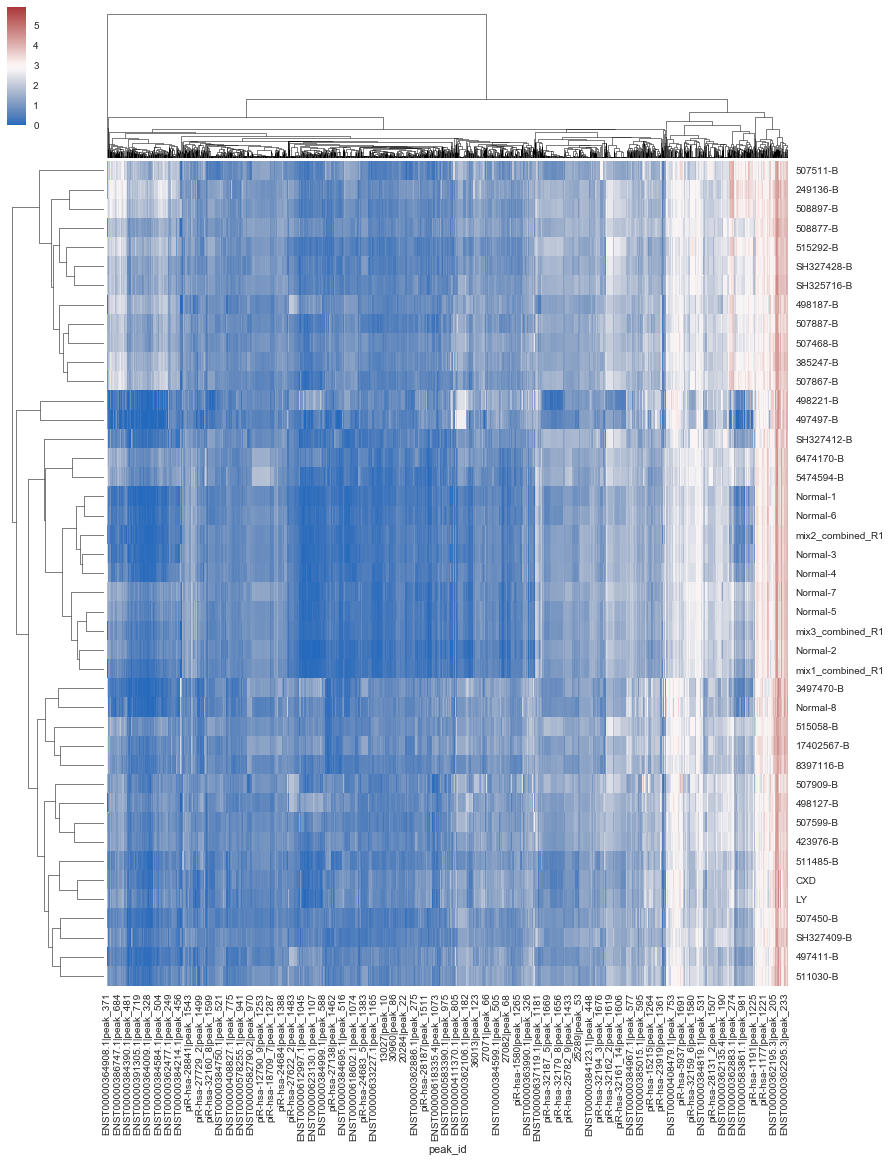

In [301]:
sns.clustermap(np.log10(X_normed + 1), cmap='vlag', figsize=(14, 18))

## Correlation between sequencing depth and raw counts

In [407]:
log_seq_depth = np.log2(X.sum(axis=1) + 1)
log_peak_counts = np.mean(np.log2(X.values + 1), axis=0)

In [409]:
log_peak_counts

array([ 6.62390019,  6.67676656,  6.70459594, ..., 13.42259973,
       10.6710647 , 11.51280977])

HBox(children=(IntProgress(value=0, max=1727), HTML(value='')))

Text(0,0.5,'Pearson correlation R')

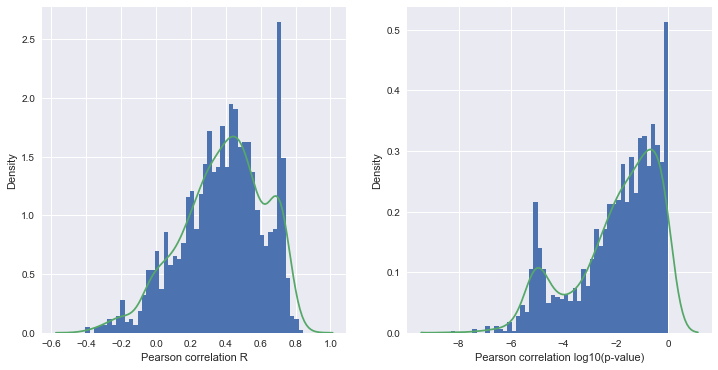

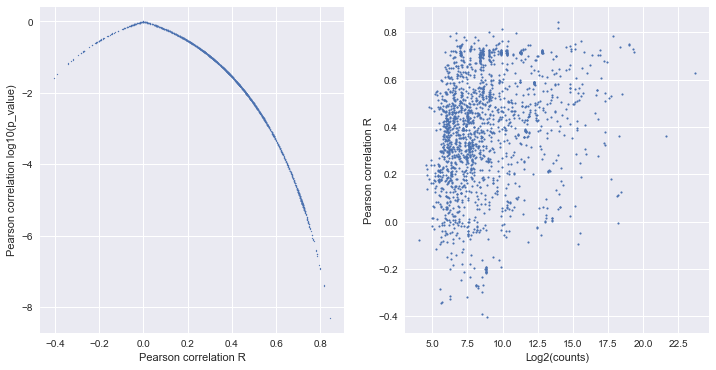

In [414]:
from scipy.stats import linregress, pearsonr

log_seq_depth = np.log2(X.sum(axis=1) + 1)
log_peak_counts = np.mean(np.log2(X.values + 1), axis=0)

pearson_rs = np.zeros(X.shape[1]) 
pearson_ps = np.zeros(X.shape[1])
for i in tqdm_notebook(range(X.shape[1])):
    pearson_rs[i], pearson_ps[i] = pearsonr(log_seq_depth[y == 1], np.log2(X.values[y == 1, i] + 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(pearson_rs, bins=50, normed=True)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Density')
sns.kdeplot(pearson_rs, ax=axes[0])

axes[1].hist(np.log10(pearson_ps), bins=50, normed=True)
axes[1].set_xlabel('Pearson correlation log10(p-value)')
axes[1].set_ylabel('Density')
sns.kdeplot(np.log10(pearson_ps), ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(pearson_rs, np.log10(pearson_ps), s=1)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Pearson correlation log10(p_value)')
axes[1].scatter(log_peak_counts, pearson_rs, s=3)
axes[1].set_xlabel('Log2(counts)')
axes[1].set_ylabel('Pearson correlation R')

Text(0,0.5,'Pearson correlation log10(p_value)')

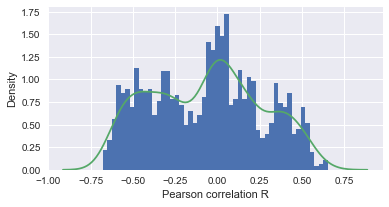

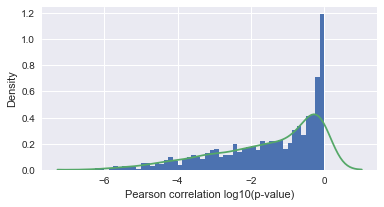

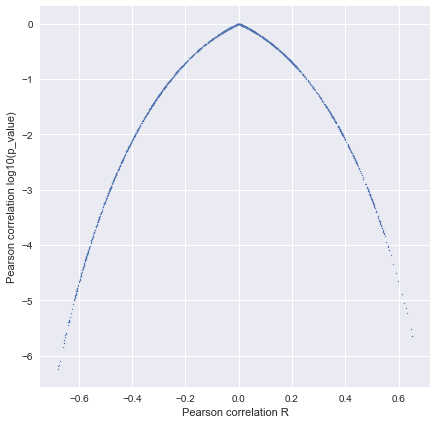

In [402]:
pearson_rs = np.zeros(X_normed.shape[1]) 
pearson_ps = np.zeros(X_normed.shape[1])
for i in range(X.shape[1]):
    pearson_rs[i], pearson_ps[i] = pearsonr(log_seq_depth, np.log2(X_normed.values[:, i] + 1))

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(pearson_rs, bins=50, normed=True)
ax.set_xlabel('Pearson correlation R')
ax.set_ylabel('Density')
sns.kdeplot(pearson_rs, ax=ax)

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(np.log10(pearson_ps), bins=50, normed=True)
ax.set_xlabel('Pearson correlation log10(p-value)')
ax.set_ylabel('Density')
sns.kdeplot(np.log10(pearson_ps), ax=ax)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(pearson_rs, np.log10(pearson_ps), s=1)
ax.set_xlabel('Pearson correlation R')
ax.set_ylabel('Pearson correlation log10(p_value)')

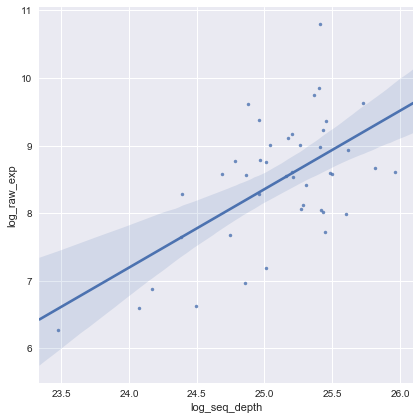

In [389]:
sns.lmplot('log_seq_depth', 'log_raw_exp', 
           data=pd.DataFrame({'log_seq_depth': log_seq_depth.values,
                              'log_raw_exp': np.log2(X.values[:, 4])}),
           size=6, scatter_kws={'s': 12})

## Robust normalization

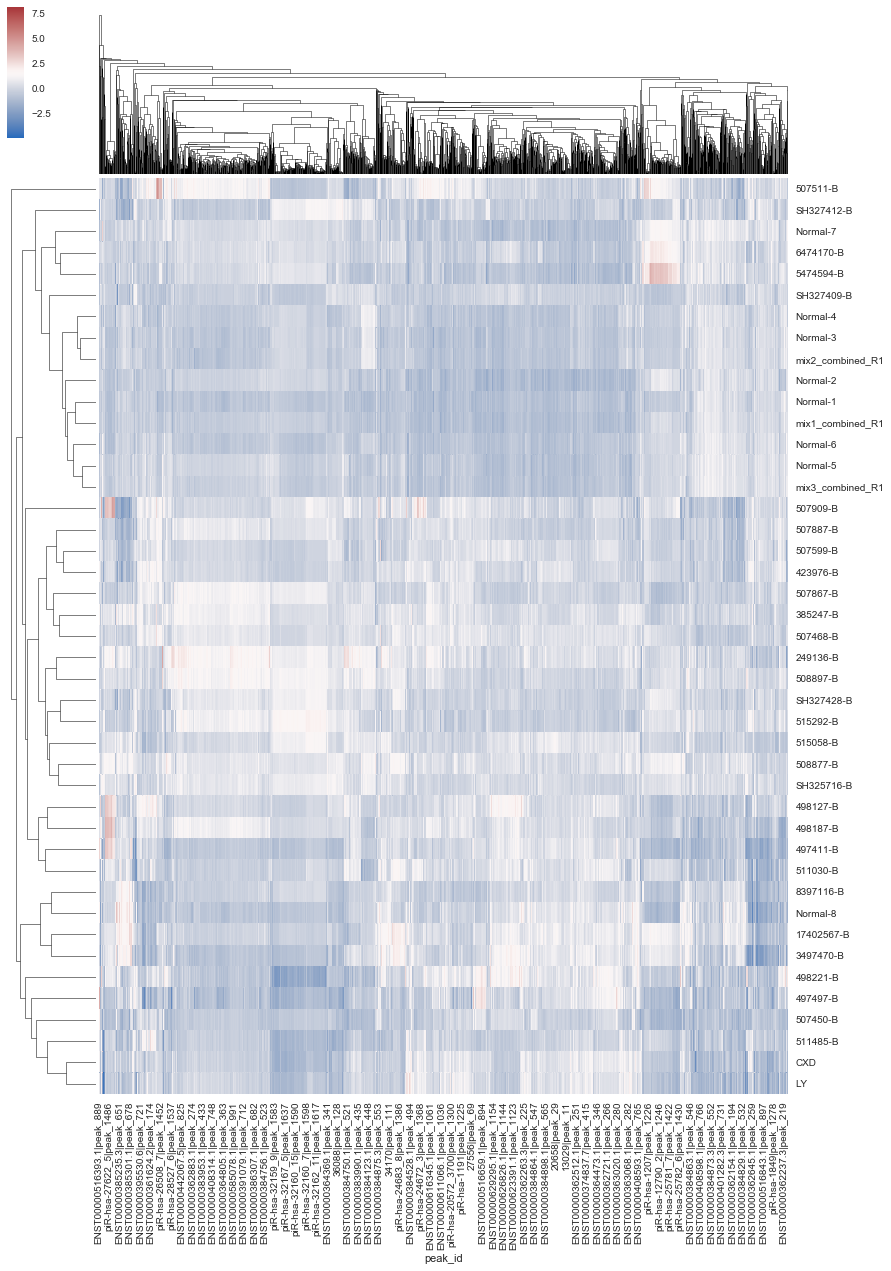

In [289]:
X_robust = RobustScaler().fit_transform(np.log2(X_normed + 1))
sns.clustermap(pd.DataFrame(X_robust, index=X.index, columns=X.columns), cmap='vlag', figsize=(14, 20))

## Z-score transformation

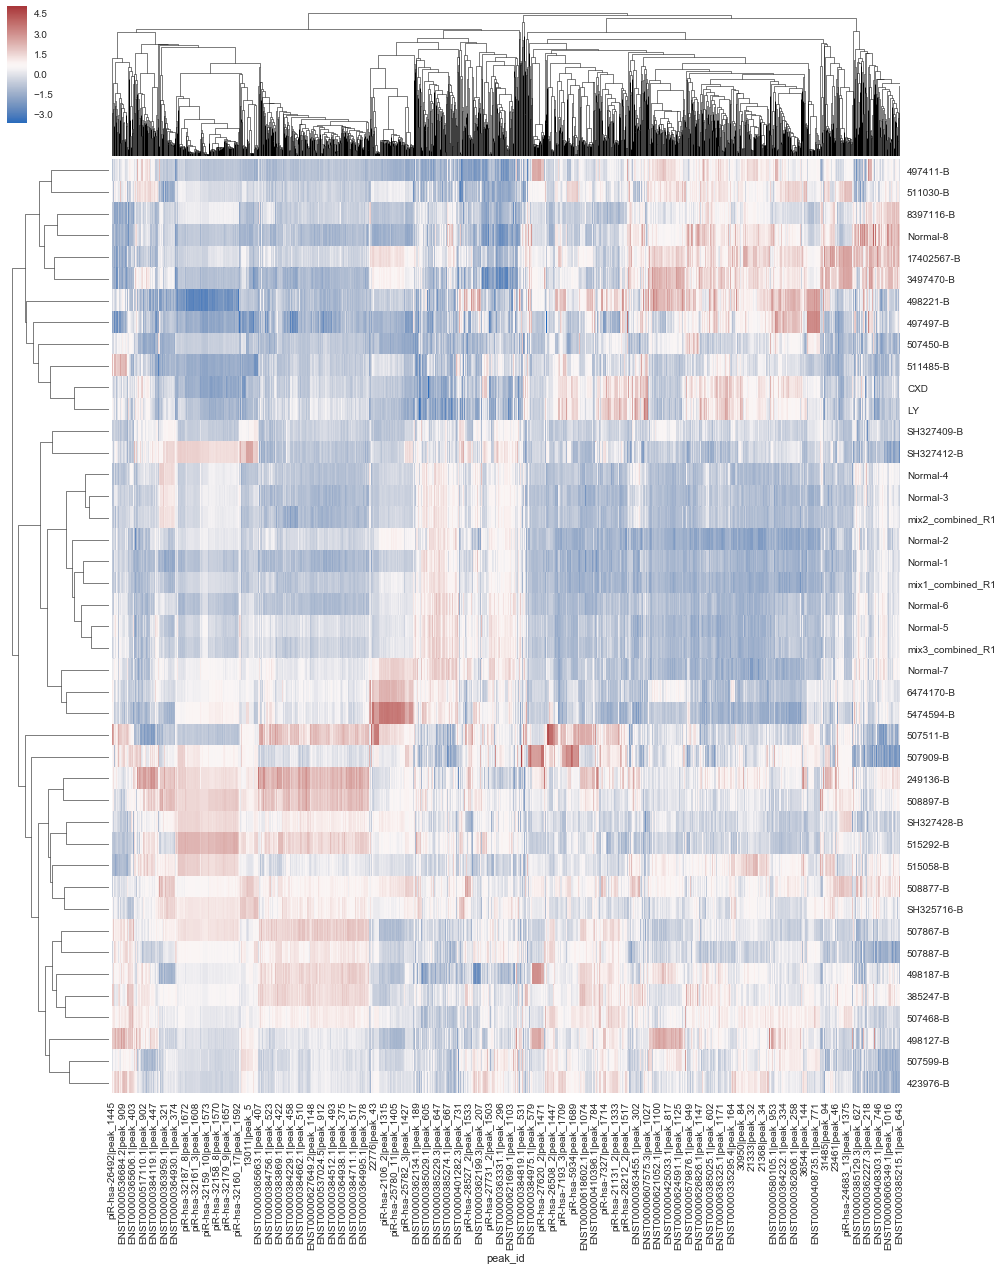

In [47]:
X_scaled = StandardScaler().fit_transform(np.log2(X_normed + 1))
sns.clustermap(pd.DataFrame(X_scaled, index=X.index, columns=X.columns), cmap='vlag', figsize=(16, 20))

## T-test for individual features

In [334]:
## T-test for individual features
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests
X_lognormed = np.log2(X_normed + 1)
t_stats = np.zeros(X_lognormed.shape[1])
t_pvals = np.zeros(X_lognormed.shape[1])
for i in range(X_lognormed.shape[1]):
    t_stats[i], t_pvals[i] = ttest_ind(X_lognormed.iloc[y == 0, i], X_lognormed.iloc[y == 1, i])
t_rejects, t_qvals, alphacSidak, alphacBonf = multipletests(t_pvals, alpha=0.001, method='fdr_bh')
t_qvals = t_qvals[t_rejects]
t_orders = np.argsort(t_qvals)
t_qvals = t_qvals[t_orders]
t_features = np.nonzero(t_rejects)[0][t_orders]
peak_labels[t_features]

array(['peak_1043|AC022929.2-201|lncRNA', 'peak_1140|HELLPAR-201|lncRNA',
       'peak_267|SNORD33-201|snoRNA', 'peak_1154|LINC00506-203|lncRNA',
       'peak_1144|HELLPAR-201|lncRNA', 'peak_1142|HELLPAR-201|lncRNA',
       'peak_1141|HELLPAR-201|lncRNA', 'peak_1118|AP000542.2-201|lncRNA',
       'peak_1156|LINC00506-203|lncRNA', 'peak_1155|LINC00506-203|lncRNA',
       'peak_1109|AC006548.3-201|lncRNA', 'peak_1143|HELLPAR-201|lncRNA',
       'peak_733|MIR885-201|miRNA', 'peak_1117|AC006548.3-201|lncRNA',
       'peak_817|AL671511.1-201|lncRNA', 'peak_608|MIR122-201|miRNA',
       'peak_1108|AC006548.3-201|lncRNA', 'peak_1134|HELLPAR-201|lncRNA',
       'peak_1133|HELLPAR-201|lncRNA', 'peak_586|MIR455-201|miRNA',
       'peak_1113|AC006548.3-201|lncRNA', 'peak_1137|HELLPAR-201|lncRNA',
       'peak_1110|AC006548.3-201|lncRNA',
       'peak_1112|AC006548.3-201|lncRNA', 'peak_1135|HELLPAR-201|lncRNA',
       'peak_1168|LINC01427-202|lncRNA', 'peak_1139|HELLPAR-201|lncRNA',
       'peak_1

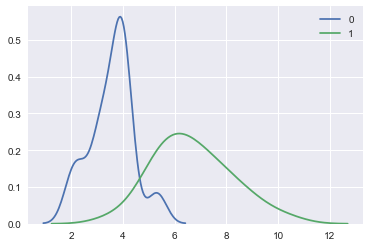

In [338]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(X_lognormed.iloc[y == 0, t_features[2]], label='0')
sns.kdeplot(X_lognormed.iloc[y == 1, t_features[2]], label='1')

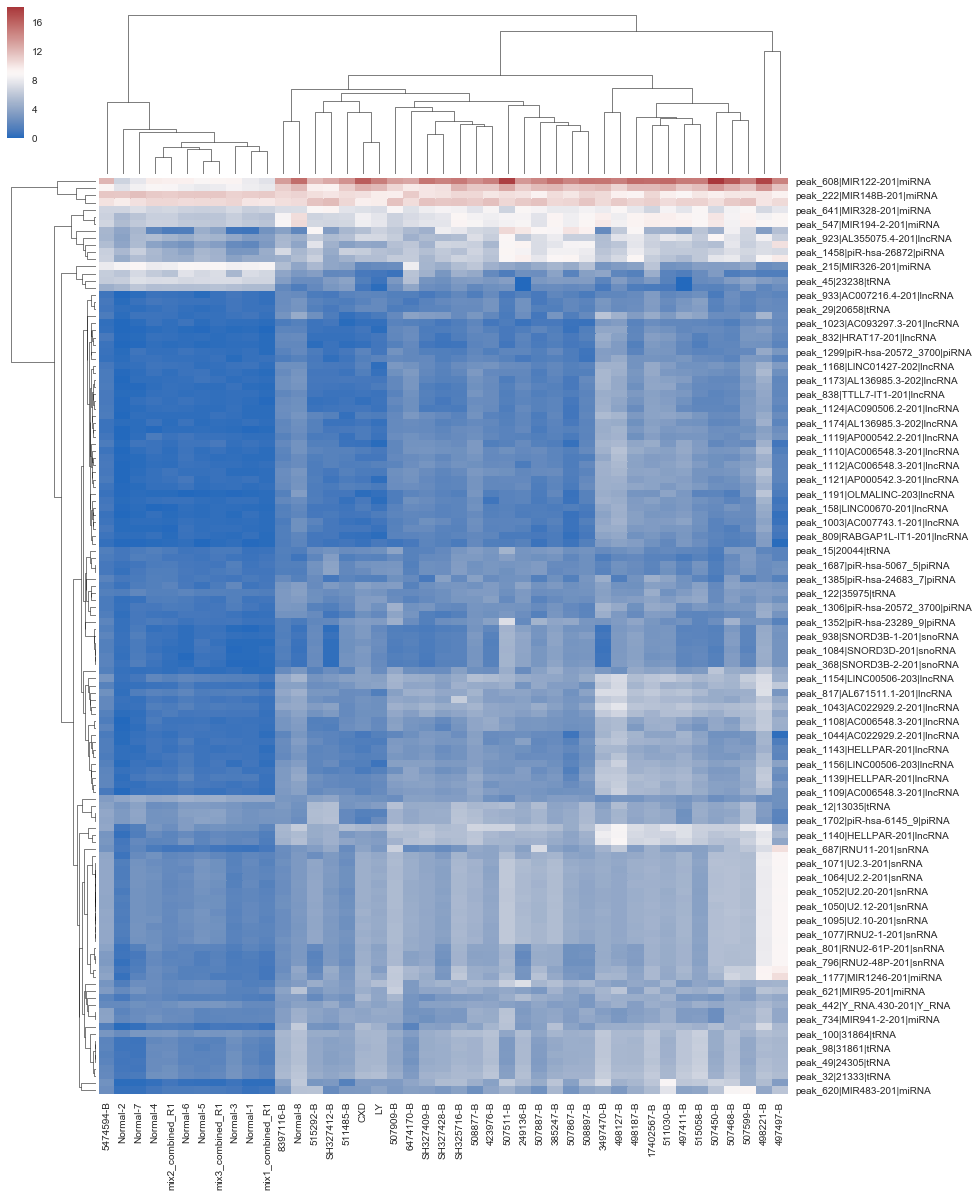

In [349]:
sns.clustermap(pd.DataFrame(X_lognormed.values, index=X.index, columns=peak_labels).iloc[:, t_features].T,
                cmap='vlag', figsize=(14, 20))

# Logistic regression

## Leave-one-out feature selection

In [292]:
n_selected_features = 50

feature_rank_matrix = np.zeros(X.shape)
#n_samples_remove = round(X.shape[0]*0.2)
n_samples_remove = 1
sample_weight = compute_sample_weight('balanced', y)
for i_run in tqdm_notebook(range(X.shape[0])):
    model = LogisticRegression()
    indices_remove = np.random.choice(X.shape[0], size=n_samples_remove)
    model.fit(np.delete(X_robust, indices_remove, axis=0),
              np.delete(y, indices_remove),
              sample_weight=np.delete(sample_weight, indices_remove))
    feature_importance = np.square(model.coef_.flatten())
    feature_orders = np.argsort(-feature_importance)
    feature_rank_matrix[i_run, feature_orders] = np.arange(X.shape[1])

HBox(children=(IntProgress(value=0, max=43), HTML(value='')))

Text(0,0.5,'Counts')

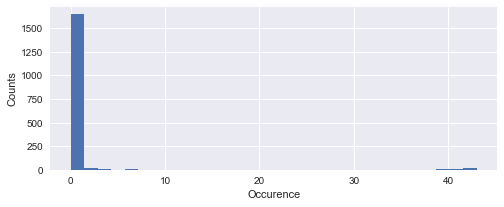

In [468]:
feature_recurrence = np.sum(feature_rank_matrix < n_selected_features, axis=0)
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(feature_recurrence, bins=30)
ax.set_xlabel('Occurence')
ax.set_ylabel('Counts')

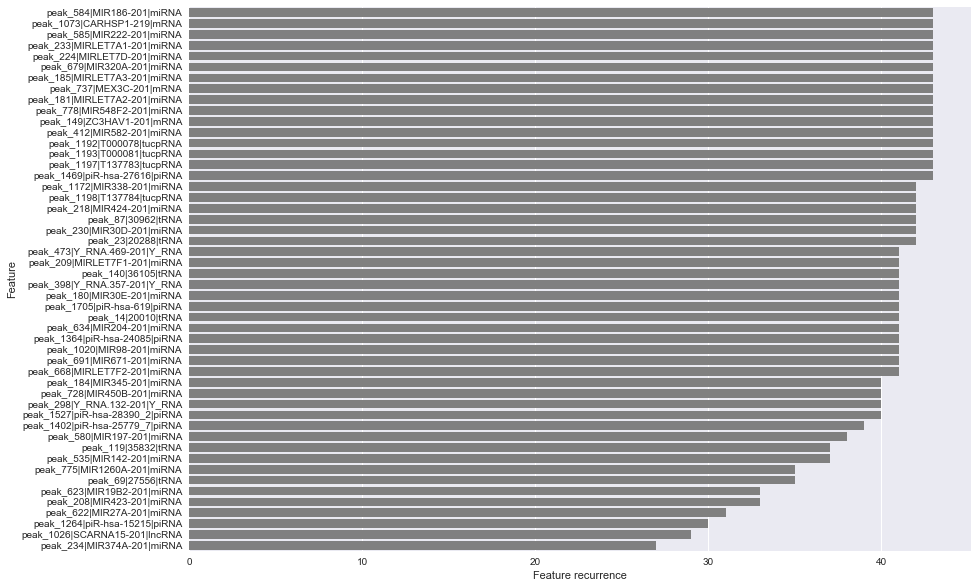

In [472]:
robust_features = np.nonzero(feature_recurrence > round(X.shape[0]*0.5))[0]
robust_features = robust_features[np.argsort(feature_recurrence[robust_features])][::-1]
#print(peak_labels[robust_features])
df = pd.DataFrame({'Feature': peak_labels[robust_features],
                   'Feature recurrence': feature_recurrence[robust_features]})
fig, ax = plt.subplots(figsize=(14, 10))
sns.barplot('Feature recurrence', 'Feature', color='gray',
           data=df, ax=ax)
pass

## Heatmap of selected features for each run

Text(106,0.5,'Feature')

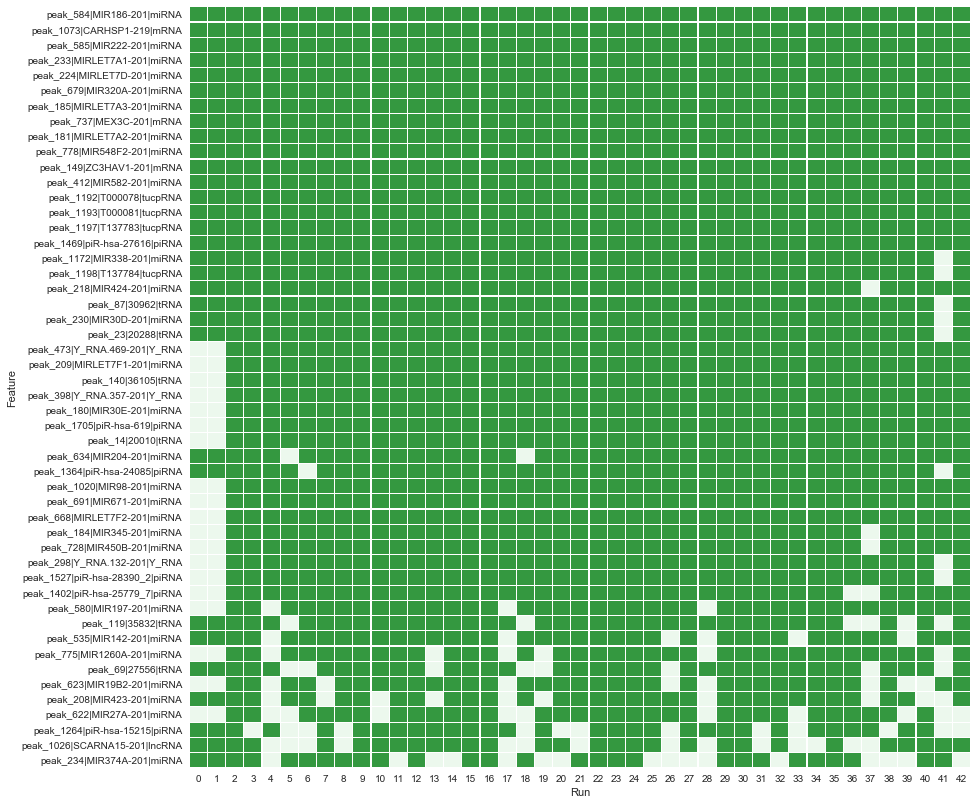

In [465]:
feature_sel_matrix = (feature_rank_matrix < n_selected_features).astype(np.int32)[:, robust_features]
fig, ax = plt.subplots(figsize=(14, 14))
cmap = sns.light_palette((127/360.0, 40/100.0, 49/100.0), n_colors=2, input='hls', as_cmap=True)
sns.heatmap(pd.DataFrame(feature_sel_matrix, index=np.arange(X.shape[0]), columns=peak_labels[robust_features]).T,
            linewidth=0.1, cmap=cmap, ax=ax, cbar=False)
ax.set_xlabel('Run')
ax.set_ylabel('Feature')

## Refit the model using robust features

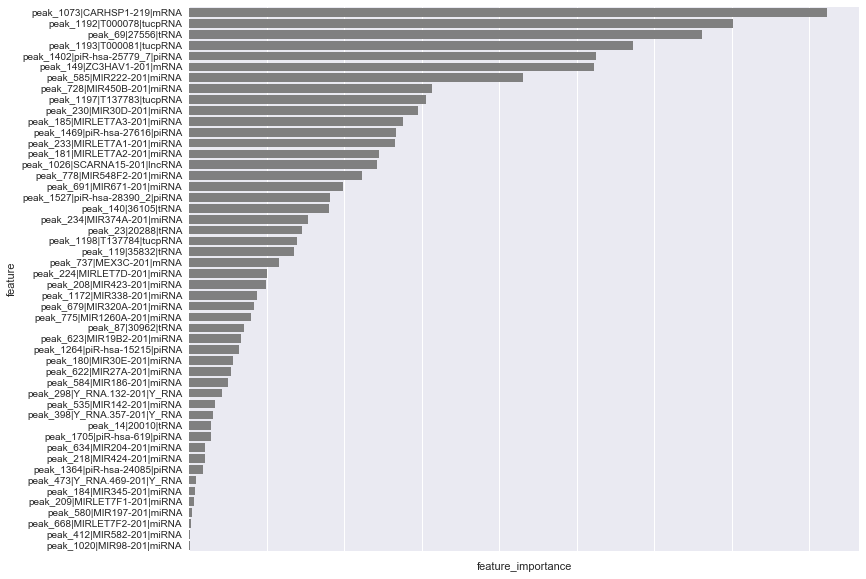

In [296]:
model = LogisticRegression()
model.fit(X_robust[:, robust_features], y, sample_weight=sample_weight)

fig, ax = plt.subplots(figsize=(12, 10))
feature_importance = np.square(model.coef_.flatten())
feature_orders = np.argsort(-feature_importance)
df = pd.DataFrame({'feature': peak_labels[robust_features[feature_orders]],
                   'feature_importance': feature_importance[feature_orders]})
sns.barplot('feature_importance', 'feature', color='gray',
           data=df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pass

## Heatmap of selected features (log counts)

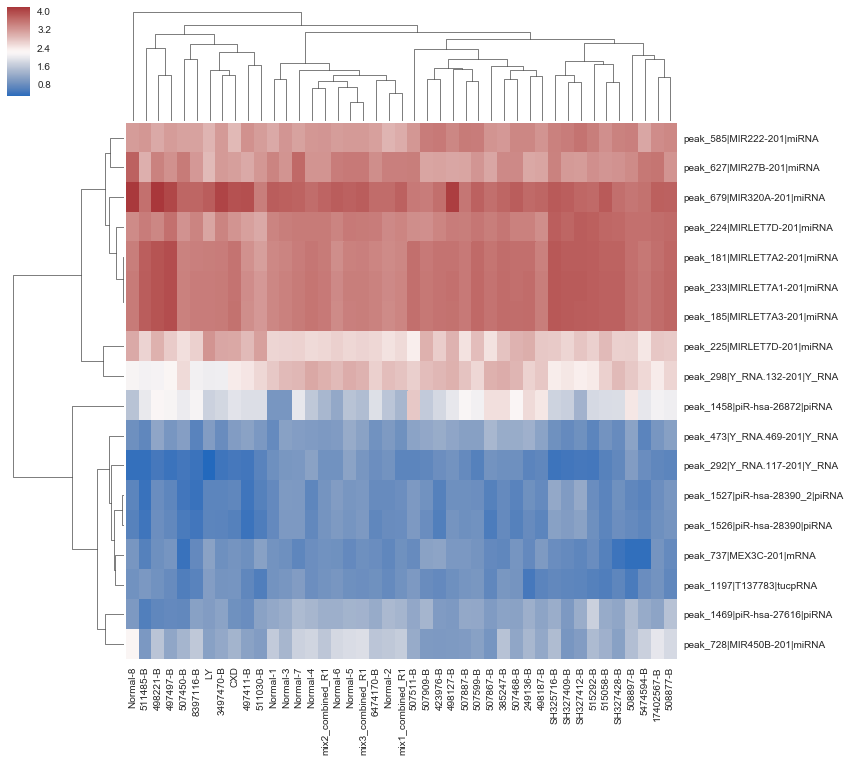

In [214]:
df = pd.DataFrame(np.log10(X_normed.values + 1), index=X.index, columns=peak_labels)
df = df.iloc[:, robust_features].T
sns.clustermap(df, cmap='vlag', figsize=(12, 12))

## Heatmap of selected features (Z-scores)

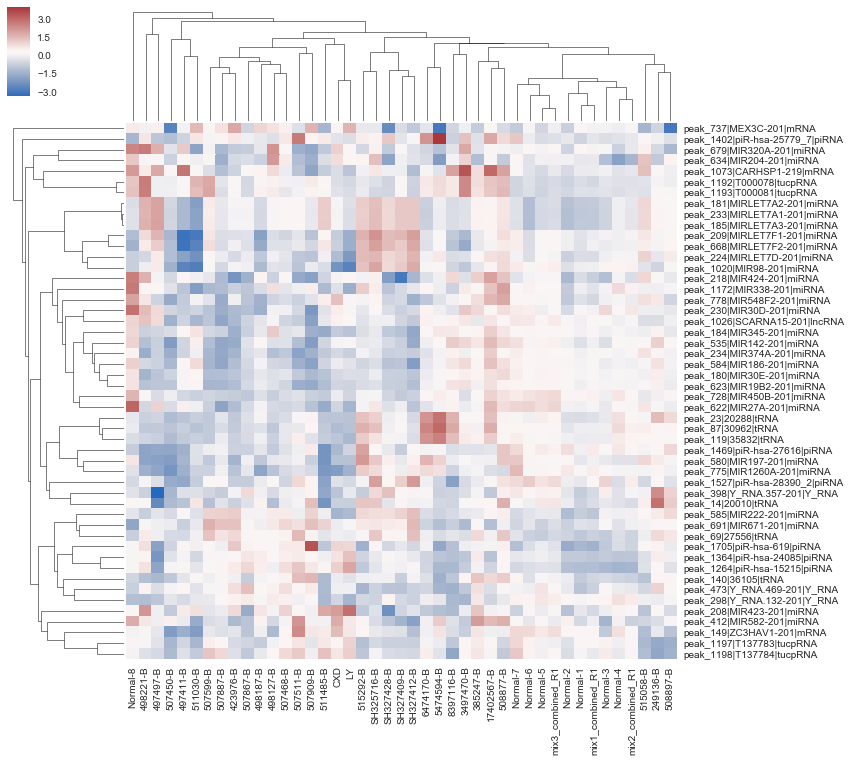

In [298]:
df = pd.DataFrame(X_robust, index=X.index, columns=peak_labels)
df = df.iloc[:, robust_features].T
sns.clustermap(df, cmap='vlag', figsize=(12, 12), row_cluster=True)

# Random forest
## Leave-one-out feature selection

In [485]:
feature_rank_matrix = np.zeros(X.shape)
n_samples_remove = 1
sample_weight = compute_sample_weight('balanced', y)
for i_run in tqdm_notebook(range(X.shape[0])):
    model = RandomForestClassifier(max_depth=4)
    indices_remove = np.random.choice(X.shape[0], size=n_samples_remove)
    model.fit(np.delete(X_robust, indices_remove, axis=0),
              np.delete(y, indices_remove),
              sample_weight=np.delete(sample_weight, indices_remove))
    feature_importance = model.feature_importances_.flatten()
    feature_orders = np.argsort(-feature_importance)
    feature_rank_matrix[i_run, feature_orders] = np.arange(X.shape[1])

HBox(children=(IntProgress(value=0, max=43), HTML(value='')))

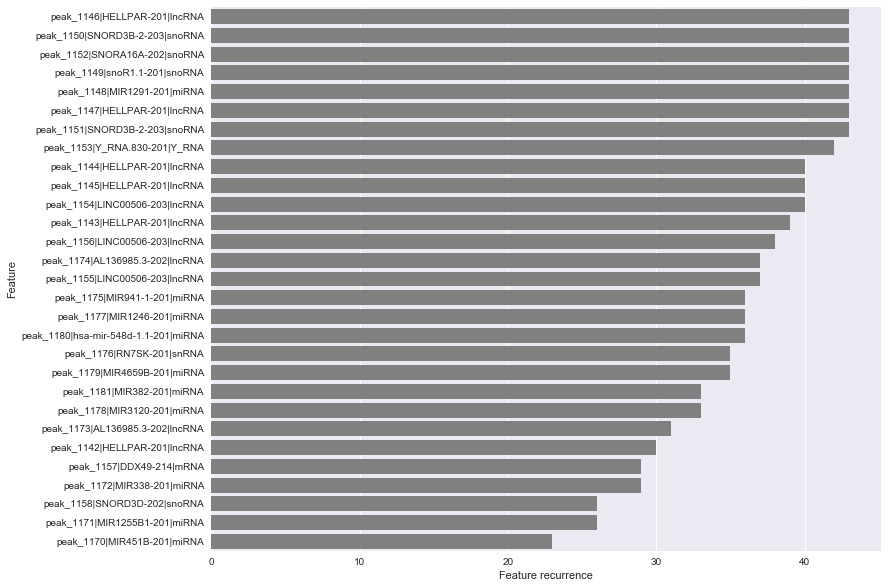

In [484]:
feature_recurrence = np.sum(feature_rank_matrix < n_selected_features, axis=0)

robust_features = np.nonzero(feature_recurrence > round(X.shape[0]*0.5))[0]
robust_features = robust_features[np.argsort(feature_recurrence[robust_features])][::-1]
#print(peak_labels[robust_features])
df = pd.DataFrame({'Feature': peak_labels[robust_features],
                   'Feature recurrence': feature_recurrence[robust_features]})
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot('Feature recurrence', 'Feature', color='gray',
           data=df, ax=ax)
pass

## Refit the model using robust features

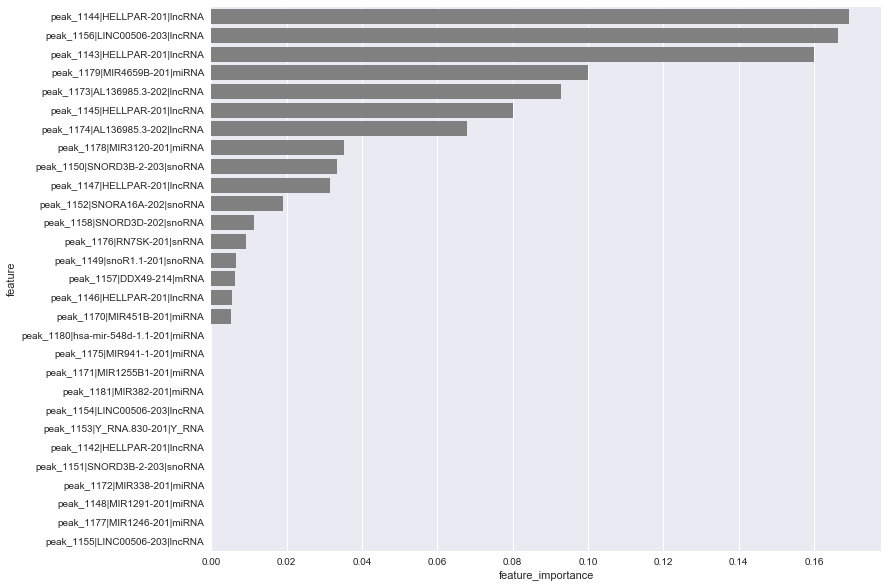

In [488]:
model = RandomForestClassifier(max_depth=4)
model.fit(X_robust[:, robust_features], y, sample_weight=sample_weight)

fig, ax = plt.subplots(figsize=(12, 10))
feature_importance = model.feature_importances_.flatten()
feature_orders = np.argsort(-feature_importance)
df = pd.DataFrame({'feature': peak_labels[robust_features[feature_orders]],
                   'feature_importance': feature_importance[feature_orders]})
sns.barplot('feature_importance', 'feature', color='gray',
           data=df, ax=ax)
pass

In [514]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LogisticRegression(), 
                           param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5]}, 
                           cv=3,
                           return_train_score=False)
grid_search.fit(X_robust[:, robust_features], y, sample_weight=sample_weight)
print(grid_search.best_params_)

{'C': 10000.0}


In [496]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [517]:
grid_search.best_estimator_.coef_

array([[ 0.24837856,  1.38821002,  3.50906321,  2.8034184 ,  0.83113511,
        -3.99232142,  1.23299677,  0.28647287,  5.12444674,  1.48831596,
         1.19547631,  2.56850359,  3.18237436,  0.20212738,  2.62570766,
         3.80863364,  1.01908088,  1.10252229, -3.09814146, -0.50724995,
         0.83188772,  4.07003991,  2.04182237,  1.94391831,  0.47770082,
        -5.72344834,  0.78014844, -1.38662348, -0.96181785]])

In [497]:
model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [506]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TTestEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, fdr_alpha=0.01, fdr_method='fdr_bh'):
        self.fdr_alpha = fdr_alpha
        self.fdr_method = fdr_method
        
    def fit(self, X, y, sample_weight=None):
        from scipy.stats import ttest_ind
        from statsmodels.sandbox.stats.multicomp import multipletests

        t_stats = np.zeros(X.shape[1])
        t_pvals = np.zeros(X.shape[1])
        for i in range(X.shape[1]):
            t_stats[i], t_pvals[i] = ttest_ind(X[y == 0, i], X[y == 1, i])
        t_rejects, t_qvals, alphacSidak, alphacBonf = multipletests(t_pvals, 
                                alpha=self.fdr_alpha, method=self.fdr_method)
        t_orders = np.argsort(t_qvals[t_rejects])
        t_features = np.nonzero(t_rejects)[0][t_orders]

        self.features_ = t_features
        self.qvalues_ = t_qvals
        self.statistics_ = t_stats
        self.feature_importances_ = -np.log10(t_qvals)
        
        return self

ttest = TTestEstimator().fit(X_robust, y)

In [509]:
ttest.features_.shape

(566,)

In [499]:
grid_search.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 

# snoRNA

## Heatmap of snoRNA expression

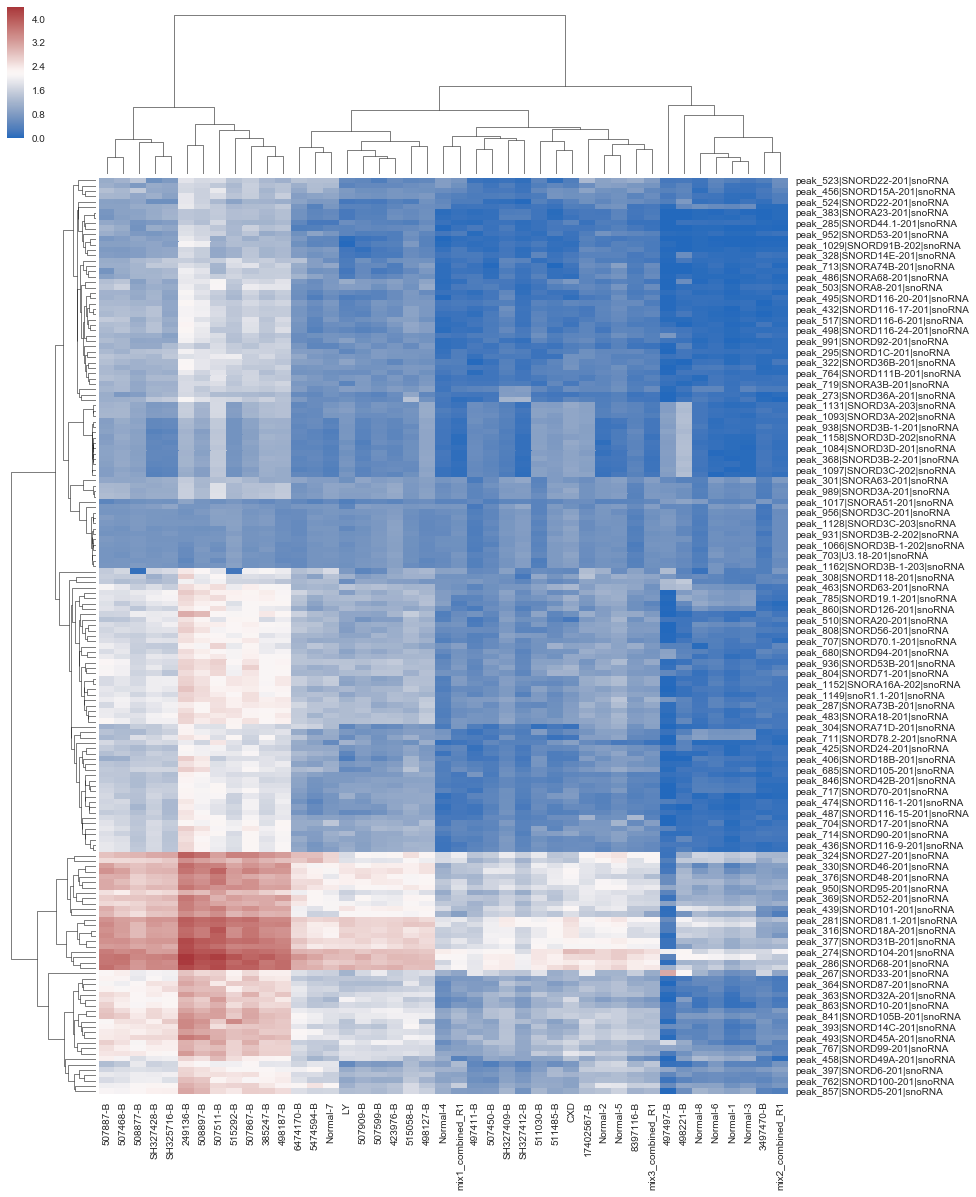

In [299]:
sns.clustermap(pd.DataFrame(np.log10(X_normed.values + 1), index=X.index, columns=peak_labels).iloc[:, peak_gene_types == 'snoRNA'].T,
                cmap='vlag', figsize=(14, 20))

In [279]:
X_snoRNA = np.log2(X_normed.values[:, peak_gene_types == 'snoRNA'] + 1).T
transcript_names_snoRNA = peak_transcript_names[peak_gene_types == 'snoRNA']
X_snoRNA

array([[2.33907787, 7.64848067, 5.9119399 , ..., 0.97889206, 0.45885723,
        1.65758431],
       [6.60153822, 9.34334967, 7.76172507, ..., 3.19861679, 3.25361432,
        3.56744797],
       [1.43214919, 6.35797239, 5.58241493, ..., 0.34319286, 0.12910252,
        0.74278186],
       ...,
       [3.0001927 , 4.02729357, 3.94972858, ..., 0.19485581, 0.5166411 ,
        0.54390326],
       [1.97866328, 1.86022627, 2.2876634 , ..., 2.2509172 , 1.90053048,
        2.15309358],
       [2.97760769, 3.97120212, 3.76369322, ..., 0.3894325 , 0.49763581,
        0.62173031]])

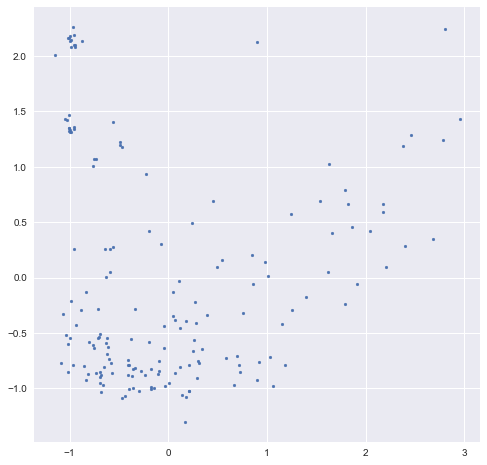

In [256]:
pca_snoRNA = PCA(n_components=2, whiten=True).fit_transform(X_snoRNA)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_snoRNA[:, 0], pca_snoRNA[:, 1], s=8)

In [267]:
from scipy.spatial import distance
distance.pdist(X_snoRNA, metric='correlation').shape

(14535,)

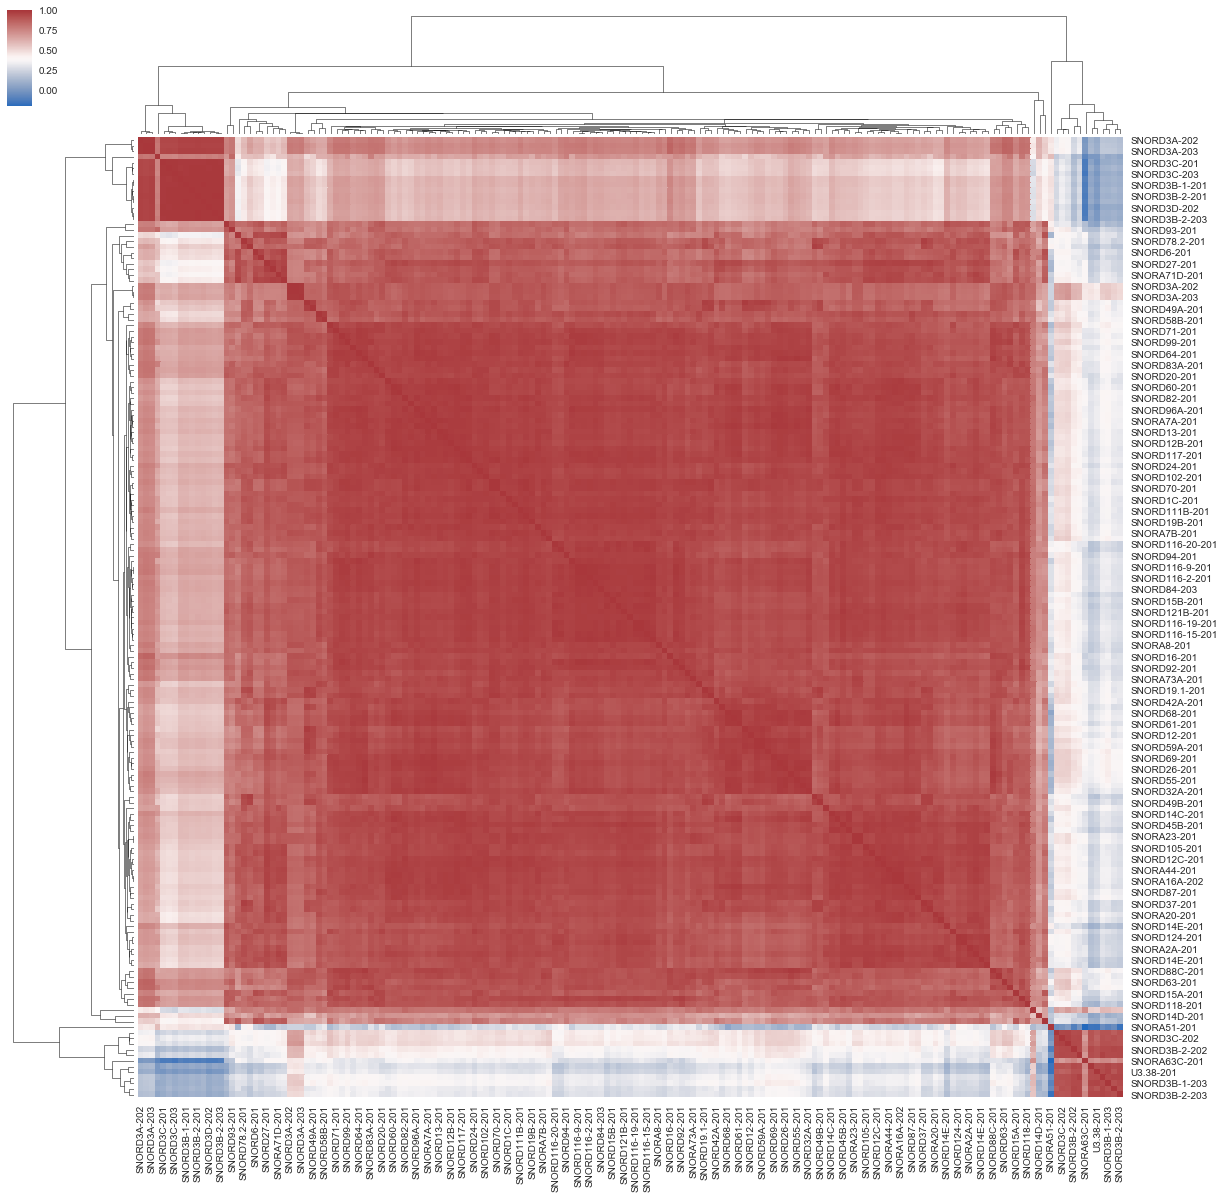

In [526]:
ii, jj = np.triu_indices(X_snoRNA.shape[0], k=1)
distmat = np.zeros((X_snoRNA.shape[0], X_snoRNA.shape[0]))
distmat[ii, jj] = distance.pdist(X_snoRNA, metric='correlation')
distmat = distmat + distmat.T
g = sns.clustermap(pd.DataFrame(1.0 - distmat, index=transcript_names_snoRNA, columns=transcript_names_snoRNA), 
               cmap='vlag', figsize=(20, 20))
g.ax_heatmap.autoscale_view()

In [521]:
vars(g.gs)

{'_col_width_ratios': [0.020000000000000004, 0.08000000000000002, 0.8],
 '_ncols': 3,
 '_nrows': 3,
 '_row_height_ratios': [0.08000000000000002, 0.020000000000000004, 0.8],
 'bottom': None,
 'hspace': 0.01,
 'left': None,
 'right': None,
 'top': None,
 'wspace': 0.01}

In [525]:
g.ax_heatmap.autoscale_view()